The aim of the study is to predict hourly electricity consumption in Turkey between 01-11-2019 and 17-11-2019 by using various methods like: Naive forecasts, linear regression and penalized regression.

# Initialization and Understand the Data

In [43]:
library(readxl)
library(glmnet)

In [44]:
# MAPE = Mean Absolute Percantage Error
MAPE = function(actual, predicted){
  result = (sum(abs(actual - predicted)/actual)*100)/length(actual)
  return(result)
}

APE = function(actual, predicted){
  result = (abs(actual - predicted)/actual)*100
  return(result)
} # In case of seeing EACH absolute percantage error value

In [45]:
setwd("C:/Users/tirya/Desktop/IE 582/Homework 3")
mydata <- read_excel('RealTimeConsumption-01012016-17112019.xlsx', sheet=1) # I convert all the names to English
mydata = data.frame(mydata)
str(mydata)

'data.frame':	33984 obs. of  7 variables:
 $ Date       : POSIXct, format: "2016-01-01" "2016-01-01" ...
 $ Hour_Real  : POSIXct, format: "1899-12-31 00:00:00" "1899-12-31 01:00:00" ...
 $ Hour       : num  0 1 2 3 4 5 6 7 8 9 ...
 $ Day        : chr  "Friday" "Friday" "Friday" "Friday" ...
 $ Lag_48     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Lag_168    : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Consumption: num  26277 24992 23533 22465 22003 ...


In [46]:
mydata = mydata[169:length(mydata$Date),] # for extracting the first 168 data to get rid of the NA's coming along lag 168.
str(mydata)
summary(mydata) # to check whether there is more NA

'data.frame':	33816 obs. of  7 variables:
 $ Date       : POSIXct, format: "2016-01-08" "2016-01-08" ...
 $ Hour_Real  : POSIXct, format: "1899-12-31 00:00:00" "1899-12-31 01:00:00" ...
 $ Hour       : num  0 1 2 3 4 5 6 7 8 9 ...
 $ Day        : chr  "Friday" "Friday" "Friday" "Friday" ...
 $ Lag_48     : num  29189 27614 26579 25719 25865 ...
 $ Lag_168    : num  26277 24992 23533 22465 22003 ...
 $ Consumption: num  28602 27112 25975 25316 25128 ...


      Date                       Hour_Real                        Hour      
 Min.   :2016-01-08 00:00:00   Min.   :1899-12-31 00:00:00   Min.   : 0.00  
 1st Qu.:2016-12-26 00:00:00   1st Qu.:1899-12-31 05:45:00   1st Qu.: 5.75  
 Median :2017-12-13 00:00:00   Median :1899-12-31 11:30:00   Median :11.50  
 Mean   :2017-12-12 22:39:15   Mean   :1899-12-31 11:30:00   Mean   :11.50  
 3rd Qu.:2018-11-30 00:00:00   3rd Qu.:1899-12-31 17:15:00   3rd Qu.:17.25  
 Max.   :2019-11-17 00:00:00   Max.   :1899-12-31 23:00:00   Max.   :23.00  
     Day                Lag_48         Lag_168       Consumption   
 Length:33816       Min.   :17796   Min.   :17796   Min.   :17796  
 Class :character   1st Qu.:28781   1st Qu.:28763   1st Qu.:28773  
 Mode  :character   Median :32933   Median :32923   Median :32926  
                    Mean   :32704   Mean   :32695   Mean   :32699  
                    3rd Qu.:36111   3rd Qu.:36113   3rd Qu.:36105  
                    Max.   :47062   Max.   :47062   M

There is no left NA in the data. We have hourly electricity consumption starting from 01-01-2016 and ending with 17-11-2019. However, the first 7 days will not be used in the predictions since they have lag 168 values.
In total, there are 1409 days and 33816 hours.

Training : 1392 days, which is 33408 hours

Test: 17 days, which is 408 hours

In [47]:
train_data = mydata[1:(length(mydata$Date)-17*24),]
test_data = mydata[(length(mydata$Date)-17*24+1):length(mydata$Date),]
# to separate the test and the training data
str(train_data)
str(test_data)

'data.frame':	33408 obs. of  7 variables:
 $ Date       : POSIXct, format: "2016-01-08" "2016-01-08" ...
 $ Hour_Real  : POSIXct, format: "1899-12-31 00:00:00" "1899-12-31 01:00:00" ...
 $ Hour       : num  0 1 2 3 4 5 6 7 8 9 ...
 $ Day        : chr  "Friday" "Friday" "Friday" "Friday" ...
 $ Lag_48     : num  29189 27614 26579 25719 25865 ...
 $ Lag_168    : num  26277 24992 23533 22465 22003 ...
 $ Consumption: num  28602 27112 25975 25316 25128 ...
'data.frame':	408 obs. of  7 variables:
 $ Date       : POSIXct, format: "2019-11-01" "2019-11-01" ...
 $ Hour_Real  : POSIXct, format: "1899-12-31 00:00:00" "1899-12-31 01:00:00" ...
 $ Hour       : num  0 1 2 3 4 5 6 7 8 9 ...
 $ Day        : chr  "Friday" "Friday" "Friday" "Friday" ...
 $ Lag_48     : num  27154 26157 25374 24911 24836 ...
 $ Lag_168    : num  29563 28243 27259 26740 26555 ...
 $ Consumption: num  29418 28134 27359 26780 26512 ...


# Approaches

## Naive Approaches

We will use first 48 and 168 hours ago consumption values as our naive approaches to predict next day's consumption. MAPE values of the each naive approaches can be seen below. Among these two approaches, the model with 168 hours has better result.

In [48]:
MAPE(test_data$Consumption, test_data$Lag_48) # Naive Prediction for lag48

[1] 7.886293

In [49]:
MAPE(test_data$Consumption, test_data$Lag_168) # Naive Prediction for lag168

[1] 3.034503

## Linear Regression Model with Lag 48 and Lag 168 Features

The linear regression model is constructed with two features: Lag 48 and Lag 168. It can be seen MAPE value of the model.

In [50]:
Model_b = lm(Consumption ~ Lag_48 + Lag_168, train_data)
summary(Model_b)
pred_Model_b = predict(Model_b, newdata = test_data)
MAPE(test_data$Consumption, pred_Model_b)


Call:
lm(formula = Consumption ~ Lag_48 + Lag_168, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-16784.6   -994.2      2.9   1022.4  15951.4 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.624e+03  9.678e+01   16.78   <2e-16 ***
Lag_48      3.257e-01  3.520e-03   92.51   <2e-16 ***
Lag_168     6.246e-01  3.518e-03  177.51   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2403 on 33405 degrees of freedom
Multiple R-squared:  0.7627,	Adjusted R-squared:  0.7627 
F-statistic: 5.368e+04 on 2 and 33405 DF,  p-value: < 2.2e-16


[1] 4.102212

## Linear Regression Models for Each Hour Separately with Lag 48 and Lag 168 Features

We perform linear regression model to each hour's electricity consumption different from the model in 2.2. By this way, instead of one big model, we formed 24 different models.

In [51]:
train_list = list()
test_list = list()
for(i in 0:23){
	train_list[[i+1]] = train_data[train_data$Hour == i,]
	test_list[[i+1]] = test_data[test_data$Hour == i,]
} # for each model, test and training lists are created

Summary_list = list() # to keep summaries for each single model
MAPE_list = list()
APE_list = list()
prediction_list = list() # to keep predictions for each model
for(i in 0:23){
	Model_hourly = lm(Consumption ~ Lag_48 + Lag_168, train_list[[i+1]])
	Summary_list[[i+1]] = summary(Model_hourly)
	prediction_list[[i+1]] = predict(Model_hourly, newdata = test_list[[i+1]])
	MAPE_list[[i+1]] = MAPE(test_list[[i+1]]$Consumption, prediction_list[[i+1]])
	APE_list[[i+1]] = APE(test_list[[i+1]]$Consumption, prediction_list[[i+1]])
}
APE_24models = 0
for(i in 1:24){
	APE_24models[(i*17-16):(i*17)] = APE_list[[i]][1:17]
} # to use in the boxplot
MAPE_24models = mean(sapply(MAPE_list, mean))
MAPE_24models

[1] 4.230636

## Penalized Regression Model

In the previous approaches, we have used very few features to predict the hourly electricity consumption. Now, we will use 48 features (hourly consumption from two days ago and last week's hourly consumption) to predict the each hour's electricity consumption by constructing different models. In the following code, it can be seen feature extraction.

In [52]:
# Firstly, we need to convert the data to wide format.
temp_var = 0 
wideformat = data.frame(temp_var)
for(i in 1:24){
	wideformat = cbind(wideformat, 0)
	names(wideformat)[i] = paste("Lag_day7_hour", i-1, sep="_")	
}
wideformat = wideformat[1,-25] # Now, temporary column is removed.
for(i in 1:24){
	wideformat = cbind(wideformat, 0)
	names(wideformat)[i+24] = paste("Lag_day2_hour", i-1, sep="_")
}
for(i in 1:24){
	wideformat = cbind(wideformat, 0)
	names(wideformat)[i+48] = paste("Consumption", i-1, sep="_")	
}

temp = 0
for(i in 1:(length(mydata[,1])/24)){	
	temp[1:24] = mydata[(i*24-23):(i*24), 6]	
	temp[25:48] = mydata[(i*24-23):(i*24), 5]
	temp[49:72] = mydata[(i*24-23):(i*24), 7]	
	wideformat = rbind(wideformat, temp)	
}
wideformat = wideformat[-1,] # to get rid of the first column having 0 values.

temp = 0
for(i in 1:(length(mydata[, 1])/24)){
	temp[i] = mydata[(i*24), 4]	
}
wideformat = cbind(wideformat, temp)
names(wideformat)[73] = paste("Day")
str(wideformat)


'data.frame':	1409 obs. of  73 variables:
 $ Lag_day7_hour_0 : num  26277 26225 27614 27103 29244 ...
 $ Lag_day7_hour_1 : num  24992 24709 25779 25440 27637 ...
 $ Lag_day7_hour_2 : num  23533 23772 24566 24395 26336 ...
 $ Lag_day7_hour_3 : num  22465 22921 23878 23961 25870 ...
 $ Lag_day7_hour_4 : num  22003 22871 23511 23861 25975 ...
 $ Lag_day7_hour_5 : num  21957 23326 23672 24418 26318 ...
 $ Lag_day7_hour_6 : num  22204 23605 23827 25709 27109 ...
 $ Lag_day7_hour_7 : num  21844 24023 23405 27455 28570 ...
 $ Lag_day7_hour_8 : num  23095 26930 24639 32982 33106 ...
 $ Lag_day7_hour_9 : num  25202 30044 26802 37176 36657 ...
 $ Lag_day7_hour_10: num  27225 32102 28780 38607 37776 ...
 $ Lag_day7_hour_11: num  28908 33432 30204 39660 38664 ...
 $ Lag_day7_hour_12: num  28789 32911 30588 38416 37522 ...
 $ Lag_day7_hour_13: num  29368 32888 30903 39279 37821 ...
 $ Lag_day7_hour_14: num  29548 32796 31056 39662 38086 ...
 $ Lag_day7_hour_15: num  29391 32595 30980 39211 37835 ..

In [54]:
# Training and the test data will be separating.
train_wide = wideformat[1:(length(wideformat[,1])-17),]
test_wide = wideformat[(length(wideformat[,1])-17+1):length(wideformat[, 1]),]
# to separate the test and the training data
str(train_wide)
str(test_wide)

'data.frame':	1392 obs. of  73 variables:
 $ Lag_day7_hour_0 : num  26277 26225 27614 27103 29244 ...
 $ Lag_day7_hour_1 : num  24992 24709 25779 25440 27637 ...
 $ Lag_day7_hour_2 : num  23533 23772 24566 24395 26336 ...
 $ Lag_day7_hour_3 : num  22465 22921 23878 23961 25870 ...
 $ Lag_day7_hour_4 : num  22003 22871 23511 23861 25975 ...
 $ Lag_day7_hour_5 : num  21957 23326 23672 24418 26318 ...
 $ Lag_day7_hour_6 : num  22204 23605 23827 25709 27109 ...
 $ Lag_day7_hour_7 : num  21844 24023 23405 27455 28570 ...
 $ Lag_day7_hour_8 : num  23095 26930 24639 32982 33106 ...
 $ Lag_day7_hour_9 : num  25202 30044 26802 37176 36657 ...
 $ Lag_day7_hour_10: num  27225 32102 28780 38607 37776 ...
 $ Lag_day7_hour_11: num  28908 33432 30204 39660 38664 ...
 $ Lag_day7_hour_12: num  28789 32911 30588 38416 37522 ...
 $ Lag_day7_hour_13: num  29368 32888 30903 39279 37821 ...
 $ Lag_day7_hour_14: num  29548 32796 31056 39662 38086 ...
 $ Lag_day7_hour_15: num  29391 32595 30980 39211 37835 ..

In [55]:
# correlation for regressors
data_for_correlation = train_wide[, 1:48]
cor(data_for_correlation)

,Lag_day7_hour_0,Lag_day7_hour_1,Lag_day7_hour_2,Lag_day7_hour_3,Lag_day7_hour_4,Lag_day7_hour_5,Lag_day7_hour_6,Lag_day7_hour_7,Lag_day7_hour_8,Lag_day7_hour_9,...,Lag_day2_hour_14,Lag_day2_hour_15,Lag_day2_hour_16,Lag_day2_hour_17,Lag_day2_hour_18,Lag_day2_hour_19,Lag_day2_hour_20,Lag_day2_hour_21,Lag_day2_hour_22,Lag_day2_hour_23
Lag_day7_hour_0,1.0000000,0.9951862,0.9881897,0.9861371,0.9816809,0.9323695,0.8192762,0.7354115,0.6231222,0.6043847,...,0.4536753,0.4762633,0.4866794,0.4809691,0.4695823,0.5227298,0.6105193,0.6418417,0.6400609,0.6529599
Lag_day7_hour_1,0.9951862,1.0000000,0.9963026,0.9931813,0.9841263,0.9232422,0.7992568,0.7163015,0.6123439,0.5935405,...,0.4410182,0.4650848,0.4742407,0.4631674,0.4478941,0.5017274,0.5917393,0.6292691,0.6291047,0.6417095
Lag_day7_hour_2,0.9881897,0.9963026,1.0000000,0.9974356,0.9877130,0.9237380,0.7971996,0.7183060,0.6223831,0.6019406,...,0.4221792,0.4471290,0.4562370,0.4438281,0.4290118,0.4847972,0.5738902,0.6138412,0.6130892,0.6250382
Lag_day7_hour_3,0.9861371,0.9931813,0.9974356,1.0000000,0.9939181,0.9393980,0.8202200,0.7458387,0.6539100,0.6322850,...,0.4138270,0.4380949,0.4477541,0.4378736,0.4271282,0.4847088,0.5726282,0.6082310,0.6055101,0.6160889
Lag_day7_hour_4,0.9816809,0.9841263,0.9877130,0.9939181,1.0000000,0.9664712,0.8622462,0.7910840,0.6992778,0.6747912,...,0.4057269,0.4289281,0.4407253,0.4375358,0.4342910,0.4951849,0.5802289,0.6046546,0.5973976,0.6050414
Lag_day7_hour_5,0.9323695,0.9232422,0.9237380,0.9393980,0.9664712,1.0000000,0.9472829,0.8774510,0.7781873,0.7461286,...,0.3589549,0.3789313,0.3986145,0.4206652,0.4449340,0.5113448,0.5672313,0.5549726,0.5373907,0.5404138
Lag_day7_hour_6,0.8192762,0.7992568,0.7971996,0.8202200,0.8622462,0.9472829,1.0000000,0.9634319,0.8702997,0.8353153,...,0.2921595,0.3048713,0.3320787,0.3871553,0.4470929,0.4943627,0.4990119,0.4685073,0.4463679,0.4493802
Lag_day7_hour_7,0.7354115,0.7163015,0.7183060,0.7458387,0.7910840,0.8774510,0.9634319,1.0000000,0.9594688,0.9357675,...,0.2477711,0.2524734,0.2702039,0.3176084,0.3758400,0.4083770,0.4167141,0.3945834,0.3778818,0.3787681
Lag_day7_hour_8,0.6231222,0.6123439,0.6223831,0.6539100,0.6992778,0.7781873,0.8702997,0.9594688,1.0000000,0.9925002,...,0.1687601,0.1654970,0.1699289,0.1968388,0.2408550,0.2712078,0.2933169,0.2816596,0.2728514,0.2683604
Lag_day7_hour_9,0.6043847,0.5935405,0.6019406,0.6322850,0.6747912,0.7461286,0.8353153,0.9357675,0.9925002,1.0000000,...,0.1857808,0.1786475,0.1773320,0.1963441,0.2318335,0.2542493,0.2763083,0.2682424,0.2666570,0.2624045


In the feature extraction, we have formed 48 features and it was probable that the features were highly correlated because of the nature of the electricity consumption. That's why, we first look at their correlation above. We have observed that lag_day_7 and lag_day_2 variables are not so highly correlated with each other; but the lag_day_7 variables are highly correlated in themselves, so are lag_day_2 variables. The most correlation is observed between consecutive hours. Since the correlation is high between features, the regular linear regression model will not work. Penalized Regression Model works better in this situation.

In [56]:
#### Lasso Model Starting

x = as.matrix(train_wide[, 1:48])
x_test = as.matrix(test_wide[, 1:48])

coefficient_Lasso_list = list() # to keep the coefficient of each model
prediction_Lasso_list = list()
MAPE_Lasso_list = 0 # to keep MAPE values for each models
APE_Lasso_list = list()
lambda_list = matrix(0, nrow = 2, ncol = 24, byrow = TRUE)
# to keep lambda.min and lambda.1se
for(i in 0:23){
	set.seed(10) # to reproduce the same result I will demonstrate
	y = as.matrix(train_wide[, 49+i])
	y_test = as.matrix(test_wide[, 49+i])
	lasso_model = cv.glmnet(x, y, type.measure = "mse",
		 alpha = 1, family = "gaussian", nfolds = 10)
	prediction_Lasso_list[[i+1]] = predict(lasso_model, newx = x_test, s = "lambda.1se")
	MAPE_Lasso_list[i+1] = MAPE(y_test, prediction_Lasso_list[[i+1]])
	APE_Lasso_list[[i+1]] = APE(y_test, prediction_Lasso_list[[i+1]])
	lambda_list[,(i+1)] = c(lasso_model$lambda.min, lasso_model$lambda.1se)
	coefficient_Lasso_list[[i+1]] = round(coef(lasso_model, s = "lambda.1se"), 3)

}





In [57]:
coefficient_Lasso_list

[[1]]
49 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept)      1526.343
Lag_day7_hour_0     0.059
Lag_day7_hour_1     .    
Lag_day7_hour_2     .    
Lag_day7_hour_3     .    
Lag_day7_hour_4     .    
Lag_day7_hour_5     .    
Lag_day7_hour_6     0.161
Lag_day7_hour_7     0.196
Lag_day7_hour_8     .    
Lag_day7_hour_9     .    
Lag_day7_hour_10    .    
Lag_day7_hour_11    0.001
Lag_day7_hour_12    0.017
Lag_day7_hour_13    .    
Lag_day7_hour_14    0.073
Lag_day7_hour_15    .    
Lag_day7_hour_16    .    
Lag_day7_hour_17    .    
Lag_day7_hour_18    .    
Lag_day7_hour_19   -0.173
Lag_day7_hour_20   -0.182
Lag_day7_hour_21    .    
Lag_day7_hour_22   -0.081
Lag_day7_hour_23    .    
Lag_day2_hour_0    -0.137
Lag_day2_hour_1    -0.026
Lag_day2_hour_2     .    
Lag_day2_hour_3     .    
Lag_day2_hour_4     .    
Lag_day2_hour_5     .    
Lag_day2_hour_6     .    
Lag_day2_hour_7     0.170
Lag_day2_hour_8     .    
Lag_day2_hour_9    -0.544
Lag_day2_hour_10

In [58]:

lambda_list # It keeps lambda.min and lambd.1se values respectively.
APE_Lasso = 0
for(i in 1:24){
	APE_Lasso[(i*17-16):(i*17)] = APE_Lasso_list[[i]][1:17]
} # to use in the boxplot
MAPE_Lasso_list # 24 MAPE values for 24 different models
mean(MAPE_Lasso_list)

0.4843384,0.6777342,0.4434421,0.8931969,0.7068845,0.6376812,0.6450944,0.5478646,0.9864961,1.094308,...,0.7235063,0.9621807,1.050364,0.6318786,0.5498241,0.6233575,0.6494002,0.4892405,0.4592666,0.4610739
7.8935096,7.6131516,8.7049479,9.1421471,7.9406039,8.6281319,8.7284354,8.9288285,13.3477641,14.806514,...,11.7913505,10.8084066,9.795732,10.2980467,8.9607636,9.2566606,8.0061088,7.2650659,9.0155904,9.0510688


[1] 1.606089 1.539897 1.597207 1.524390 1.462112 1.381842 1.513556 2.085582
 [9] 2.860758 3.391373 3.665808 3.921997 3.997281 4.034540 4.401782 4.007299
[17] 3.547527 2.688397 1.964566 1.943288 1.615921 1.725218 1.851883 1.578983

[1] 2.496137

"lambda.min" gives minimum mean cross-validated error.
"lambda.1se" gives the most regularized model such that error is within one standard error of the minimum.
To get better test results, it is more suitable to pick "lambda.1se".
When we look at the results above, we can see that Lasso Model has given different solutions for each model. The hours in midday (let say between 10 a.m.-2.p.m.), the model gives worse solutions. On average, MAPE is better than the other models.

# Comparison of the Approaches

We compare the models according to their MAPE values. It can be seen MAPE values of the five different approaches below:
Naive Model with lag 48, Naive Model with lag 168, Linear Regression, Linear Regression (24 model), Penalized Regression Model with L1 (Lasso Regression).

In [59]:
(Lag_48_MAPE = MAPE(test_data$Consumption, test_data$Lag_48))
(Lag_168_MAPE = MAPE(test_data$Consumption, test_data$Lag_168))
(Lin_Reg_MAPE = MAPE(test_data$Consumption, pred_Model_b))
(Lin_Reg_Hourly_MAPE = MAPE_24models)
(Lasso_MAPE = mean(MAPE_Lasso_list))

[1] 7.886293

[1] 3.034503

[1] 4.102212

[1] 4.230636

[1] 2.496137

According to MAPE values, we can clearly say that Penalized Regression Model with L1 (Lasso Regression) has the best performance on the test data. In addition to MAPE, for each individual predictions, which are APE values, are better in Lasso Regression again. You can also see this in the boxplot below. While the maximum APE value is about 12-13% in Lasso Regression, the other models can give more than 20%.

Then, we pick Penalized Regression Model with L1 (Lasso Regression) for this case.

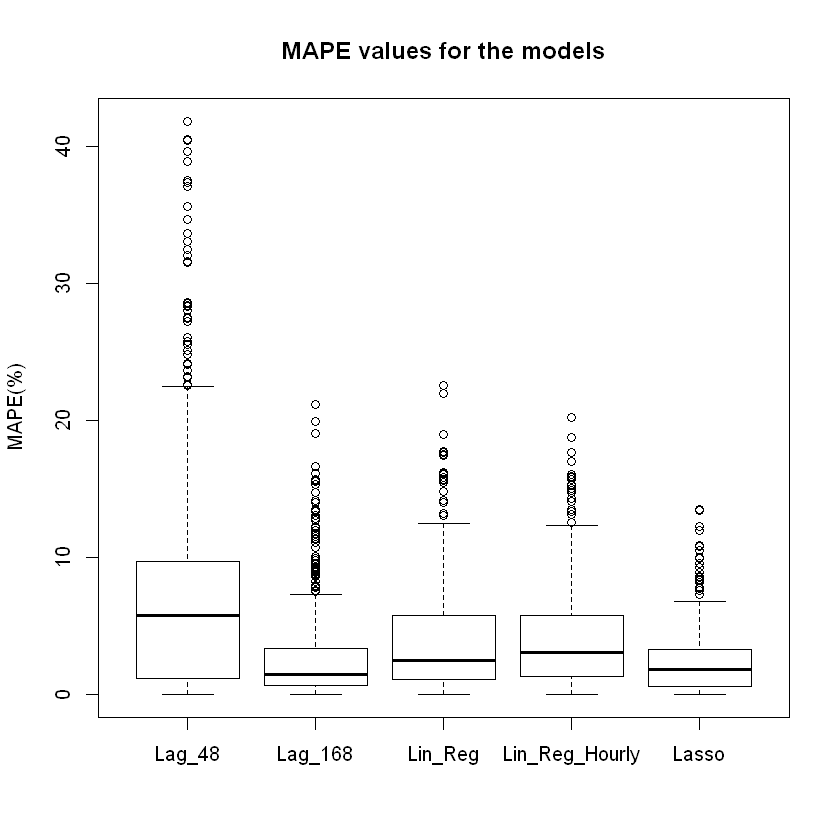

In [60]:
Lag_48_APE = APE(test_data$Consumption, test_data$Lag_48)
Lag_168_APE = APE(test_data$Consumption, test_data$Lag_168)
Lin_Reg_APE = APE(test_data$Consumption, pred_Model_b)
Lin_Reg_Hourly_APE = APE_24models
Lasso_APE = APE_Lasso
boxplot(Lag_48_APE, Lag_168_APE, Lin_Reg_APE, Lin_Reg_Hourly_APE,
	 Lasso_APE, main = "MAPE values for the models", 
	 names = c("Lag_48", "Lag_168", "Lin_Reg",
	 "Lin_Reg_Hourly", "Lasso"), ylab = "MAPE(%)")